### Combining GDP data with the jobs report

Brian Dew

Updated: September 20, 2020

----

Notes:

The basic idea here is to use the BEA population estimates plus CPS employment rate and hours worked trends to estimate GDP per hour of work. BLS does this process for its productivity and costs report, using much more comprehensive data, however this approximation has proven decent over time.

The hard part to this measure is getting hours worked right. All of the published measures are either too-low-frequency or don't have a broad enough definition of workers. I want to capture all workers, regardless of full-time or part-time status or of whether they work for the private sector. Also want to capture second and third jobs. As a result, I selected total actual hours worked from the CPS microdata, specifically finding the trend using x13as with default settings. Hours worked from the CPS microdata have issues around holidays falling in the reference week, and also do not capture hours worked for some important categories of labor such as self-employed persons.

In [1]:
%matplotlib inline
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

qtrs = {1: 1, 2: 1, 3: 1, 4: 2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4}

In [2]:
avghrs = lambda x: np.average(x.HRSACTT.replace(-1, 0), weights=x.WGT)
aah, epop = {}, {}
cols = ['HRSACTT', 'LFS', 'MONTH']
for year in range(1989, 2023):
    wgt = 'PWSSWGT' if year >= 1998 else 'BASICWGT'
    df = pd.read_feather(cps_dir / f'cps{year}.ft', 
                         columns=cols + [wgt]).rename({wgt: 'WGT'}, axis=1)
    emp = df.query('LFS == "Employed"')
    ah = (emp.groupby('MONTH').apply(avghrs))
    aah.update({pd.to_datetime(f'{year}-{month}-01'): value 
                for month, value in list(zip(ah.index, ah.values))})
    ep = (emp.groupby('MONTH').WGT.sum() / df.groupby('MONTH').WGT.sum())
    epop.update({pd.to_datetime(f'{year}-{month}-01'): value 
                 for month, value in list(zip(ep.index, ep.values))})

In [3]:
sm = x13_arima_analysis(pd.Series(epop))
epop_sa = sm.seasadj.resample('QS').mean()
sm = x13_arima_analysis(pd.Series(aah))
aah_sa = sm.trend.resample('QS').mean()

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


In [4]:
gdp_code = ('T10106', ['A191RX'])
pop_code = ('T70100', ['B230RC'])
cd = nipa_df(retrieve_table('T10105')['Data'], ['A191RC'])['A191RC'].iloc[-1]
rgdp = nipa_df(retrieve_table('T10106')['Data'], ['A191RX'])
gdp = rgdp / rgdp.iloc[-1] * cd
pop = nipa_df(retrieve_table(pop_code[0])['Data'], pop_code[1]).sort_index()

df = pd.DataFrame()
df['epop'] = epop_sa * 100
df['pop'] = pop['B230RC'] / 1000
#df['hours'] = fred_df('PRS84006023')
df['hours'] = aah_sa
df['gdp'] = gdp['A191RX']
df['input'] = (df['pop'] * (df['epop'] / 100)) * (df['hours'] * 52)
df['gdpinp'] = df['gdp'] / df['input']
datetxt = dtxt(df['gdpinp'].dropna().index[-1])['qtr1']
write_txt(text_dir / 'gdpjobs_ltdt.txt', datetxt)
df.to_csv(data_dir / 'gdpjobslvl.csv', index_label='date')

df['epop_c'] = ((df['pop'] * df['epop'].mean()) * df['hours']) * df['gdpinp']
df['pop_c'] = ((df['pop'].mean() * df['epop']) * df['hours']) * df['gdpinp']
df['hours_c'] = ((df['pop'] * df['epop']) * df['hours'].mean()) * df['gdpinp']

df_g = growth_rate(df.dropna())

df_g['pop_contr'] = df_g['gdp'] - df_g['pop_c']
df_g['epop_contr'] = df_g['gdp'] - df_g['epop_c']
df_g['hours_contr'] = df_g['gdp'] - df_g['hours_c']
df_g['prod'] = (df_g['gdp'] - df_g['pop_contr'] - 
                df_g['epop_contr'] - df_g['hours_contr'])
result = df_g[['pop_contr', 'epop_contr', 'hours_contr', 'prod']].round(2)
result.to_csv(data_dir / 'gdpjobs.csv', index_label='date')

In [5]:
data = df.dropna()

ltval = f"\${data['gdpinp'].iloc[-1]:.2f}"
prval = f"\${data['gdpinp'].iloc[-2]:.2f}"
prdate = dtxt(data['gdpinp'].index[-2])['qtr1']
prdt = '2019-10-01'
prval2 = f"\${data.loc[prdt, 'gdpinp']:.2f}"
prval3 = f"\${data.loc['2015-10-01', 'gdpinp']:.2f}"
val89 = f"\${data.loc['1989-01-01', 'gdpinp']:.2f}"
gdpval = f"\${data['gdp'].iloc[-1] / 1_000:,.0f}"
gdppr = f"\${data.loc[prdt, 'gdp'] / 1_000:,.0f}"
agghrs = f"{data['input'].iloc[-1] / 1_000:,.0f}"
hrspr = f"{data.loc[prdt, 'input'] / 1_000:,.0f}"

text = (f'In {datetxt}, real GDP was equivalent to roughly {ltval} '+
        f'per hour of work, compared to {prval} in {prdate}, {prval2} '+
        f'in 2019 Q4, {prval3} in 2015 Q4, and {val89} in the first quarter '+
        'of 1989.\n\nComparing the latest data to the pre-COVID data covering '+
        f'2019 Q4, annualized real GDP is {gdpval} billion in the latest data '+
        f'and {gdppr} billion in 2019 Q4. Aggregate hours worked total '+
        f'{agghrs} billion in the latest quarter and {hrspr} billion '+
        'in 2019 Q4.')
write_txt(text_dir / 'gdp_per_hour.txt', text)
print(text, '\n\n')

poplt = value_text(result['pop_contr'].iloc[-1], style='contribution_to', 
                   ptype='pp', digits=2)
poppr = value_text(result.loc[prdt, 'pop_contr'], style='contribution', 
                   ptype='pp', digits=2, casual=True)
emplt = value_text(result['epop_contr'].iloc[-1], style='contribution', 
                   ptype='pp', digits=2)
emppr = value_text(result.loc[prdt, 'epop_contr'], style='contribution', 
                   ptype='pp', digits=2, casual=True)
hrslt = value_text(result['hours_contr'].iloc[-1], style='contribution_to', 
                   ptype='pp', digits=2, casual=True)
hrspr = value_text(result.loc[prdt, 'hours_contr'], style='contribution', 
                   ptype='pp', digits=2, casual=True)
prodlt = value_text(result['prod'].iloc[-1], style='contribution_to', 
                    ptype='pp', digits=2)
prodpr = value_text(result.loc[prdt, 'prod'], style='contribution_of', 
                    ptype='pp', digits=2, casual=True)

text = (f'In {datetxt}, population growth {poplt} annualized GDP growth, '+
        f'and, for comparison, {poppr} in 2019 Q4. Changes in the '+
        f'employed share of the population {emplt} in the latest quarter, '+
        f'and {emppr} in the fourth quarter of 2019. Changes in average '+
        f'hours worked {hrslt} GDP growth in the latest quarter and {hrspr} '+
        f'in 2019 Q4. Lastly, productivity {prodlt} GDP growth in {datetxt}, '+
        f'compared to {prodpr} in 2019 Q4.')
write_txt(text_dir / 'gdpjobsch.txt', text)
print(text)

In 2022 Q3, real GDP was equivalent to roughly \$82.36 per hour of work, compared to \$81.82 in 2022 Q2, \$77.31 in 2019 Q4, \$75.04 in 2015 Q4, and \$50.28 in the first quarter of 1989.

Comparing the latest data to the pre-COVID data covering 2019 Q4, annualized real GDP is \$25,724 billion in the latest data and \$24,648 billion in 2019 Q4. Aggregate hours worked total 312 billion in the latest quarter and 319 billion in 2019 Q4. 


In 2022 Q3, population growth contributed 0.37 percentage point to annualized GDP growth, and, for comparison, added 0.59 percentage point in 2019 Q4. Changes in the employed share of the population contributed 0.80 percentage point in the latest quarter, and added 1.66 percentage points in the fourth quarter of 2019. Changes in average hours worked subtracted 0.60 percentage point from GDP growth in the latest quarter and added 0.38 percentage point in 2019 Q4. Lastly, productivity contributed 2.67 percentage points to GDP growth in 2022 Q3, compared to

In [6]:
df

,epop,pop,hours,gdp,input,gdpinp,epop_c,pop_c,hours_c
1989-01-01,48.433198,246.460,37.432191,1.168187e+07,232347.593395,50.277569,2.222498e+07,2.691165e+07,2.244730e+07
1989-04-01,48.388751,247.017,37.458852,1.177104e+07,232824.706711,50.557503,2.241519e+07,2.705592e+07,2.260254e+07
1989-07-01,48.467951,247.698,37.481785,1.185824e+07,233991.871057,50.678020,2.254436e+07,2.718143e+07,2.275606e+07
1989-10-01,48.425322,248.374,37.485046,1.188161e+07,234444.495319,50.679848,2.260867e+07,2.716087e+07,2.279892e+07
1990-01-01,48.348861,248.936,37.479558,1.201145e+07,234569.617250,51.206347,2.289188e+07,2.739569e+07,2.305144e+07
...,...,...,...,...,...,...,...,...,...
2021-10-01,47.815851,332.584,37.151654,2.566175e+07,307223.720000,83.527905,4.945230e+07,4.380860e+07,4.968269e+07
2022-01-01,48.297054,332.749,37.143342,2.555645e+07,310400.009212,82.333933,4.875869e+07,4.360720e+07,4.948990e+07
2022-04-01,48.525137,332.940,37.124421,2.551949e+07,311885.921744,81.823156,4.845932e+07,4.351915e+07,4.944351e+07
2022-07-01,48.619233,333.241,37.070596,2.572394e+07,312319.746685,82.364120,4.875302e+07,4.382818e+07,4.991199e+07


<AxesSubplot: >

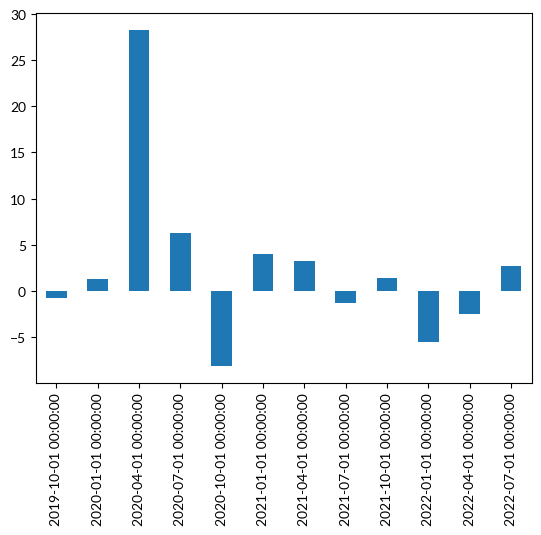

In [7]:
growth_rate(df['gdpinp'].dropna()).iloc[-12:].plot(kind='bar')